In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from functools import partial
from collections import deque
%matplotlib inline
from scipy.integrate import solve_ivp
import sympy as sym
sym.init_printing()

In [95]:
class Small_Pendulum:
    def __init__(self, m=1, l=1, g=9.81, initial_theta=0, initial_omega=0, time = 10, dt = 0.01):
        self.m = m # mass of the pendulum
        self.l = l # length of the pendulum
        self.g = g # gravitational acceleration

        
        # small pendulum equation: theta'' + g/l * theta = 0
        sol = solve_ivp(lambda t, y : [y[1], -g/l * y[0]], [0, time], [initial_theta, initial_omega], t_eval=np.arange(0, time, dt))
        
        self.t = sol.t
        self.thetas = sol.y[0]
        self.omegas = sol.y[1]
        self.alphas = -g/l * sol.y[0]
        
        self.x = self.l*np.sin(self.thetas) # x position
        self.y = -self.l*np.cos(self.thetas) # y position


class Pendulum:
    def __init__(self, m=1, l=1, g=9.81, initial_theta=0, initial_omega=0, time = 10, dt = 0.01):
        self.m = m # mass of the pendulum
        self.l = l # length of the pendulum
        self.g = g # gravitational acceleration

        
        # pendulum equation: theta'' + g/l * sin(theta) = 0
        sol = solve_ivp(lambda t, y : [y[1], -g/l * np.sin(y[0])], [0, time], [initial_theta, initial_omega], t_eval=np.arange(0, time, dt))
        
        self.t = sol.t
        self.thetas = sol.y[0]
        self.omegas = sol.y[1]
        self.alphas = -g/l * sol.y[0]
        
        self.x = self.l*np.sin(self.thetas) # x position
        self.y = -self.l*np.cos(self.thetas) # y position
        


In [96]:
initial_theta = np.pi+0.3
pendulum = Pendulum(initial_theta=initial_theta, time = 20)
small_pendulum = Small_Pendulum(initial_theta=initial_theta, time = 20)

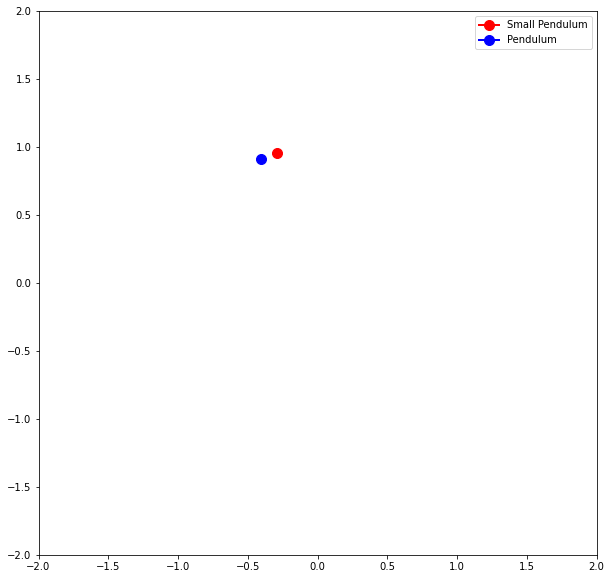

In [99]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
 

axes.set_ylim(-2,2)
axes.set_xlim(-2,2)

line1, = axes.plot([], [], lw = 2, color = 'red', marker = 'o', markersize = 10)
line2, = axes.plot([], [], lw = 2, color = 'blue', marker = 'o', markersize = 10)

axes.legend([line1, line2], ['Small Pendulum', 'Pendulum'])

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2,


# animation function
def animate(i):
    x0, y0 = small_pendulum.x[i], small_pendulum.y[i]
    x1, y1 = pendulum.x[i], pendulum.y[i]
    # x, y values to be plotted
    line1.set_data(x0, y0)
    line2.set_data(x1, y1)
    return line1, line2,
 
# calling the animation function    
anim = animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames = 400,
                            interval = 20,
                            blit = True)
anim.save('pend.mp4', writer = 'ffmpeg', fps = 30)

### Double Pendulum

System Set-up

In [261]:
g, t = sym.symbols('g t')

In [262]:
t1 = sym.Function('theta1')(t)
t2 = sym.Function('theta2')(t)
dt1 = sym.diff(t1, t)
dt2 = sym.diff(t2, t)
ddt1 = sym.diff(dt1, t)
ddt2 = sym.diff(dt2, t)

In [263]:
x1 = sym.sin(t1)
y1 = -sym.cos(t1)
x2 = x1 + sym.sin(t2)
y2 = y1 - sym.cos(t2)

Lagrangian

In [264]:
T = sym.S(1)/2 * (sym.diff(x1, t)**2 + sym.diff(y1, t)**2 + sym.diff(x2, t)**2 + sym.diff(y2, t)**2)
U = -g * (y1 + y2)
L = (T - U).simplify()

Euler-Lagrange Equations

In [265]:
del_L_t1 = sym.diff(L, t1)
del_L_t2 = sym.diff(L, t2)
d_del_L_dt1 = sym.diff(sym.diff(L, dt1), t).simplify()
d_del_L_dt2 = sym.diff(sym.diff(L, dt2), t).simplify()

In [266]:
L_1 = sym.Eq(del_L_t1, d_del_L_dt1)
L_2 = sym.Eq(del_L_t2, d_del_L_dt2)

Solve for second derivatives

In [267]:
sol = sym.solve([L_1, L_2], [ddt1, ddt2])
ddt1 = sol[ddt1]
ddt2 = sol[ddt2]

Put in form of a system of first order ODEs:
$$ \underline{\dot{z}} = f(t,\underline{z})$$

$$ \underline{z} = [\theta_1, \dot{\theta}_1,\theta_2, \dot{\theta}_2] \implies \underline{\dot{z}} = [\dot{\theta}_1, \ddot{\theta}_1,\dot{\theta}_2, \ddot{\theta}_2]$$

In [268]:
dt1_val = sym.lambdify(dt1, dt1)
ddt1_val = sym.lambdify((t1, t2, dt1, dt2, g), ddt1)
dt2_val = sym.lambdify(dt2, dt2)
ddt2_val = sym.lambdify((t1, t2, dt1, dt2, g), ddt2)

In [269]:
def dbl_pendulum_state(t, th, g=9.81):
    th1, dt1, th2, dt2 = th
    return np.array([dt1, ddt1_val(th1, th2, dt1, dt2, g), dt2,  ddt2_val(th1, th2, dt1, dt2, g)])

In [270]:
c = solve_ivp(dbl_pendulum_state, [0, 10], [np.pi+0.3,  0, np.pi+0.2, 0], t_eval=np.arange(0, 10, 0.01))

In [271]:
th1 = c.y[0]
dth1 = c.y[1]
th2 = c.y[2]
dth2 = c.y[3]
x1 = np.sin(th1)
y1 = -np.cos(th1)
x2 = x1 + np.sin(th2)
y2 = y1 - np.cos(th2)

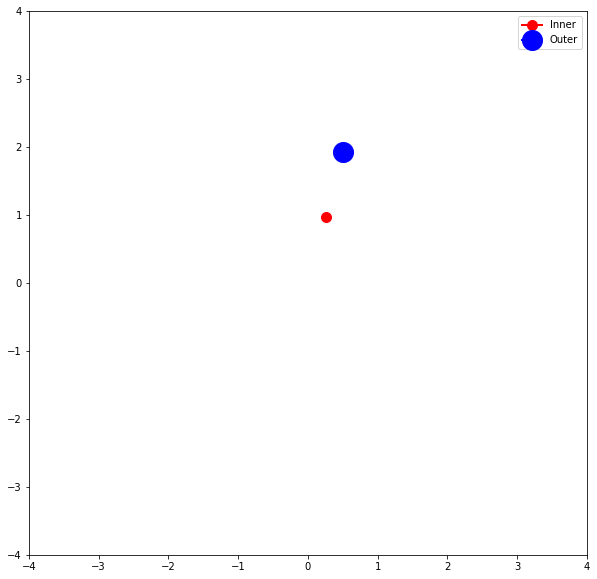

In [272]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
 

axes.set_ylim(-4,4)
axes.set_xlim(-4,4)

line1, = axes.plot([], [], lw = 2, color = 'red', marker = 'o', markersize = 10)
line2, = axes.plot([], [], lw = 2, color = 'blue', marker = 'o', markersize = 20)

axes.legend([line1, line2], ['Inner', 'Outer'])

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2,


# animation function
def animate(i):
    # x, y values to be plotted
    line1.set_data(x1[i], y1[i])
    line2.set_data(x2[i], y2[i])
    return line1, line2,
 
# calling the animation function    
anim = animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames = 400,
                            interval = 20,
                            blit = True)
anim.save('pend.mp4', writer = 'ffmpeg', fps = 30)